<div align="center" style="font-size: 24px; font-weight: bold;">Electrical and Computer Engineering Department</div>
<div align="center" style="font-size: 18px;font-weight: bold;">First Semester, 2023/2024</div>
<div align="center" style="font-size: 20px; font-weight: bold;">Intelligent Systems Lab ‐ ENCS5141</div>
<div align="center" style="font-size: 18px; font-weight: bold;">Assignment #3: Image Segmentation with Clustering Algorithms</div>
<hr>
<div align="center" style="font-size: 16px;">Prepared by: Mohammad AbuJaber</div>
<div align="center" style="font-size: 16px;">ID: 1190298</div>
<div align="center" style="font-size: 16px;">Instructor: Dr. Mohammad Jubran</div>
<div align="center" style="font-size: 16px;">Assistant's Name: Eng. Hanan Awawdeh</div>
<div align="center" style="font-size: 16px;">Section: 3</div>
<div align="center" style="font-size: 16px;">Date: 12th January 2024</div>
<hr>


Import all needed libraries


In [10]:
import os
import random
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

The `calculate_iou` function calculates the intersection over union (IoU) between two binary masks, the true mask from the dataset and the predicted one. The `calculate_all_metrics` function evaluates segmentation quality using metrics like silhouette_score, calinski_harabasz_score, and Davies-Bouldin index. These functions are commonly used in image segmentation tasks to evaluate the accuracy of segmentation models. The metrics provide different perspectives on the quality of clusters in a dataset. The silhouette score focuses on the separation and cohesion of individual points; Calinski-Harabasz emphasizes the ratio of between-cluster to within-cluster variance; and Davies-Bouldin considers both compactness and separation of clusters. Researchers and practitioners often use a combination of these metrics to comprehensively evaluate clustering results.


In [11]:
def calculate_iou(mask_true, mask_pred):
    # Ensure both masks have the same shape
    if mask_true.shape != mask_pred.shape:
        mask_pred = mask_pred[:, :, 0]  # Take only the first channel (assuming it's binary)

    intersection = np.logical_and(mask_true, mask_pred)
    union = np.logical_or(mask_true, mask_pred)
    iou = np.sum(intersection) / np.sum(union)

    return iou

def calculate_all_metrics(mask, segmented_labels, image):
    iou = calculate_iou(mask.flatten(), segmented_labels.flatten())
    silhouette = silhouette_score(image.reshape((-1, 3)), segmented_labels.flatten())
    calinski_harabasz = calinski_harabasz_score(image.reshape((-1, 3)), segmented_labels.flatten())
    davies_bouldin = davies_bouldin_score(image.reshape((-1, 3)), segmented_labels.flatten())
    return iou, silhouette, calinski_harabasz, davies_bouldin

The following code loads four random images with their masks from the dataset and prints their paths.


In [12]:
dataset_path = "/kaggle/input/assignment-3/images_and_masks"

def load_images(image_path, mask_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))  # Resize for visualization

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
    mask = cv2.resize(mask, (256, 256))

    return image, mask


# Choose 4 random images
image_names = random.sample(os.listdir(os.path.join(dataset_path, 'images')), 4)

# Create a list to store image and mask paths
image_paths = [os.path.join(dataset_path, 'images', name) for name in image_names]
mask_paths = [os.path.join(dataset_path, 'masks', name.replace('.jpg', '.png')) for name in image_names]

print(f"Image paths: {image_paths}\n")
print(f"Mask paths: {mask_paths}\n")

Image paths: ['/kaggle/input/assignment-3/images_and_masks/images/225_00330.png', '/kaggle/input/assignment-3/images_and_masks/images/591_00120.png', '/kaggle/input/assignment-3/images_and_masks/images/648_00150.png', '/kaggle/input/assignment-3/images_and_masks/images/624_00330.png']

Mask paths: ['/kaggle/input/assignment-3/images_and_masks/masks/225_00330.png', '/kaggle/input/assignment-3/images_and_masks/masks/591_00120.png', '/kaggle/input/assignment-3/images_and_masks/masks/648_00150.png', '/kaggle/input/assignment-3/images_and_masks/masks/624_00330.png']



# K-Means


In [13]:
def run_kmeans(num_clusters):
    def apply_kmeans(image, method='RGB'):
        if method == 'RGB':
            # Reshape the image for K-means clustering
            image_flattened = image.reshape((-1, image.shape[-1]))
        elif method == 'RGB_XY':
            # Feature Space Setup 2: RGB + XY Coordinates
            xy_coordinates = np.column_stack(np.where(np.ones_like(mask)))
            xy_coordinates = xy_coordinates.astype(np.float32)  # Convert to float32
            xy_coordinates /= 255.0  # Normalize coordinates to [0, 1]
            image_with_xy = np.concatenate([image, xy_coordinates.reshape(image.shape[0], image.shape[1], -1)], axis=-1)
            image_flattened = image_with_xy.reshape((-1, image_with_xy.shape[-1]))
        elif method == 'RGB_Standardized':
            # Standardize RGB features before clustering
            scaler = StandardScaler()
            image_flattened = scaler.fit_transform(image.reshape((-1, 3)))
        else:
            raise ValueError("Invalid clustering method. Choose from 'RGB', 'RGB_XY', or 'RGB_Standardized'.")
        
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=20)
        kmeans.fit(image_flattened)
        segmented_image = kmeans.labels_.reshape(image.shape[:2])

        # Normalize pixel values to [0, 1]
        segmented_image = segmented_image / np.max(segmented_image)

        return segmented_image, kmeans.labels_

    
    average_iou_list = []
    average_silhouette_list = []
    average_calinski_harabasz_list = []
    average_davies_bouldin_list = []
    # Set up a subplot grid
    fig, axes = plt.subplots(4, 5, figsize=(20, 15))

    # Iterate over image and mask paths
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Load and preprocess the image and mask
        image, mask = load_images(image_path, mask_path)

        # Apply K-means clustering to the original image
        kmeans_output, segmented_labels = apply_kmeans(image, method='RGB')

        # Plot the original image
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        # Plot the mask
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Mask {i+1}")

        # Plot the output of K-means clustering (RGB)
        axes[i, 2].imshow(kmeans_output)
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"K-means (RGB) Output {i+1}")

        # Calculate and print metrics for K-means (RGB)
        iou, silhouette, calinski_harabasz, davies_bouldin = calculate_all_metrics(mask, segmented_labels, image)
        print(f"\nMetrics for K-means (RGB) Image {i+1}:")
        print(f"IoU: {iou}")
        print(f"Silhouette Score: {silhouette}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz}")
        print(f"Davies-Bouldin Index: {davies_bouldin}")

        # Apply K-means clustering to the image with x-y coordinates
        kmeans_output_xy, segmented_labels_xy = apply_kmeans(image, method='RGB_XY')

        # Plot the output of K-means clustering (RGB + x-y)
        axes[i, 3].imshow(kmeans_output_xy)
        axes[i, 3].axis('off')
        axes[i, 3].set_title(f"K-means (RGB + x-y) Output {i+1}")

        # Calculate and print metrics for K-means (RGB + x-y)
        iou_xy, silhouette_xy, calinski_harabasz_xy, davies_bouldin_xy = calculate_all_metrics(mask, segmented_labels_xy, image)
        print(f"\nMetrics for K-means (RGB + x-y) Image {i+1}:")
        print(f"IoU: {iou_xy}")
        print(f"Silhouette Score: {silhouette_xy}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_xy}")
        print(f"Davies-Bouldin Index: {davies_bouldin_xy}")

        # Apply K-means clustering to the standardized image
        kmeans_output_std, segmented_labels_std = apply_kmeans(image, method='RGB_Standardized')

        # Plot the output of K-means clustering (RGB + Standardized)
        axes[i, 4].imshow(kmeans_output_std)
        axes[i, 4].axis('off')
        axes[i, 4].set_title(f"K-means (RGB + Standardized) Output {i+1}")

        # Calculate and print metrics for K-means (RGB + Standardized)
        iou_std, silhouette_std, calinski_harabasz_std, davies_bouldin_std = calculate_all_metrics(mask, segmented_labels_std, image)
        print(f"\nMetrics for K-means (RGB + Standardized) Image {i+1}:")
        print(f"IoU: {iou_std}")
        print(f"Silhouette Score: {silhouette_std}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_std}")
        print(f"Davies-Bouldin Index: {davies_bouldin_std}")
        
        average_iou_list.extend([iou, iou_xy, iou_std])
        average_silhouette_list.extend([silhouette, silhouette_xy, silhouette_std])
        average_calinski_harabasz_list.extend([calinski_harabasz, calinski_harabasz_xy, calinski_harabasz_std])
        average_davies_bouldin_list.extend([davies_bouldin, davies_bouldin_xy, davies_bouldin_std])
        
    # Calculate average metrics for each case of GMM
    average_iou_rgb = np.mean(average_iou_list[0:3])
    average_iou_rgb_standardized = np.mean(average_iou_list[3:6])
    average_iou_rgb_xy = np.mean(average_iou_list[6:9])

    average_silhouette_rgb = np.mean(average_silhouette_list[0:3])
    average_silhouette_rgb_standardized = np.mean(average_silhouette_list[3:6])
    average_silhouette_rgb_xy = np.mean(average_silhouette_list[6:9])

    average_calinski_harabasz_rgb = np.mean(average_calinski_harabasz_list[0:3])
    average_calinski_harabasz_rgb_standardized = np.mean(average_calinski_harabasz_list[3:6])
    average_calinski_harabasz_rgb_xy = np.mean(average_calinski_harabasz_list[6:9])

    average_davies_bouldin_rgb = np.mean(average_davies_bouldin_list[0:3])
    average_davies_bouldin_rgb_standardized = np.mean(average_davies_bouldin_list[3:6])
    average_davies_bouldin_rgb_xy = np.mean(average_davies_bouldin_list[6:9])

    # Print results
    print("\nAverage IoU:")
    print(f"K-means RGB: {average_iou_rgb}")
    print(f"K-means RGB + Standardized: {average_iou_rgb_standardized}")
    print(f"K-means RGB + XY: {average_iou_rgb_xy}")

    print("\nAverage Silhouette Score:")
    print(f"K-means RGB: {average_silhouette_rgb}")
    print(f"K-means RGB + Standardized: {average_silhouette_rgb_standardized}")
    print(f"K-means RGB + XY: {average_silhouette_rgb_xy}")

    print("\nAverage Calinski-Harabasz Index:")
    print(f"K-means RGB: {average_calinski_harabasz_rgb}")
    print(f"K-means RGB + Standardized: {average_calinski_harabasz_rgb_standardized}")
    print(f"K-means RGB + XY: {average_calinski_harabasz_rgb_xy}")

    print("\nAverage Davies-Bouldin Index:")
    print(f"K-means RGB: {average_davies_bouldin_rgb}")
    print(f"K-means RGB + Standardized: {average_davies_bouldin_rgb_standardized}")
    print(f"K-means RGB + XY: {average_davies_bouldin_rgb_xy}")

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

## Discussing the code

The provided code applies K-means clustering to a set of images using different feature spaces and evaluates the results using several metrics. The key aspects of the code are as follows:

1. Feature Spaces:
   The script uses K-means clustering to analyze three feature spaces: RGB, RGB + XY coordinates, and RGB after standardization. RGB represents each pixel's RGB values, while RGB + XY includes XY coordinates normalized to [0, 1]. RGB after standardization scales RGB values using standard scaling.
2. Clustering and Evaluation:
   The script performs K-means clustering on each feature space with k clusters, computes and prints evaluation metrics for each image, and calculates average metrics across all images for each feature space.
3. Results and Analysis:
   The script evaluates the impact of clustering quality on clustering quality by printing results for three different k values. It calculates and displays average metrics for each feature space and k value. The script compares the results between RGB and RGB + Standardized and RGB and RGB + XY to study the effect of standardizing features.

#### Qualitative Assessment:

To assess the quality of clustered images qualitatively, one can examine the visual outputs (segmented images) for each feature space and each value of k. This involves observing how well the algorithm separates different regions in the images.

#### Quantitative Evaluation:

The quantitative evaluation is based on metrics such as IoU, silhouette score, Calinski-Harabasz index, and Davies-Bouldin index. These metrics provide numerical measures of the performance of the clustering algorithm.

#### Analysis:

Average metrics are calculated to provide an overall performance summary for each feature space and each value of k.
The impact of the number of clusters is studied by comparing results for k = 2, k = 3, and k = 10.
The effect of standardizing features is assessed by comparing results between RGB and RGB + Standardized.
The effect of adding XY coordinates as features is studied by comparing the results between RGB and RGB + XY.

#### Interpretation:

A higher IoU and silhouette score and a lower Davies-Bouldin index and Calinski-Harabasz index generally indicate better clustering performance.
Qualitatively, visually inspecting the segmented images can provide insights into the clustering quality.



Metrics for K-means (RGB) Image 1:
IoU: 0.0021908127208480565
Silhouette Score: 0.6581233852483926
Calinski-Harabasz Index: 119466.8028520155
Davies-Bouldin Index: 0.46975911549462407

Metrics for K-means (RGB + x-y) Image 1:
IoU: 0.0021908127208480565
Silhouette Score: 0.6581233852483926
Calinski-Harabasz Index: 119466.8028520155
Davies-Bouldin Index: 0.46975911549462407

Metrics for K-means (RGB + Standardized) Image 1:
IoU: 0.22825716234652116
Silhouette Score: 0.658182940760767
Calinski-Harabasz Index: 119460.14721199877
Davies-Bouldin Index: 0.46952845206170746

Metrics for K-means (RGB) Image 2:
IoU: 0.09147972833916444
Silhouette Score: 0.6617022082398611
Calinski-Harabasz Index: 213314.14375147127
Davies-Bouldin Index: 0.4522299596378636

Metrics for K-means (RGB + x-y) Image 2:
IoU: 0.041057519840782326
Silhouette Score: 0.6616701196444574
Calinski-Harabasz Index: 213313.6703007847
Davies-Bouldin Index: 0.4523516011399066

Metrics for K-means (RGB + Standardized) Image 2:
IoU

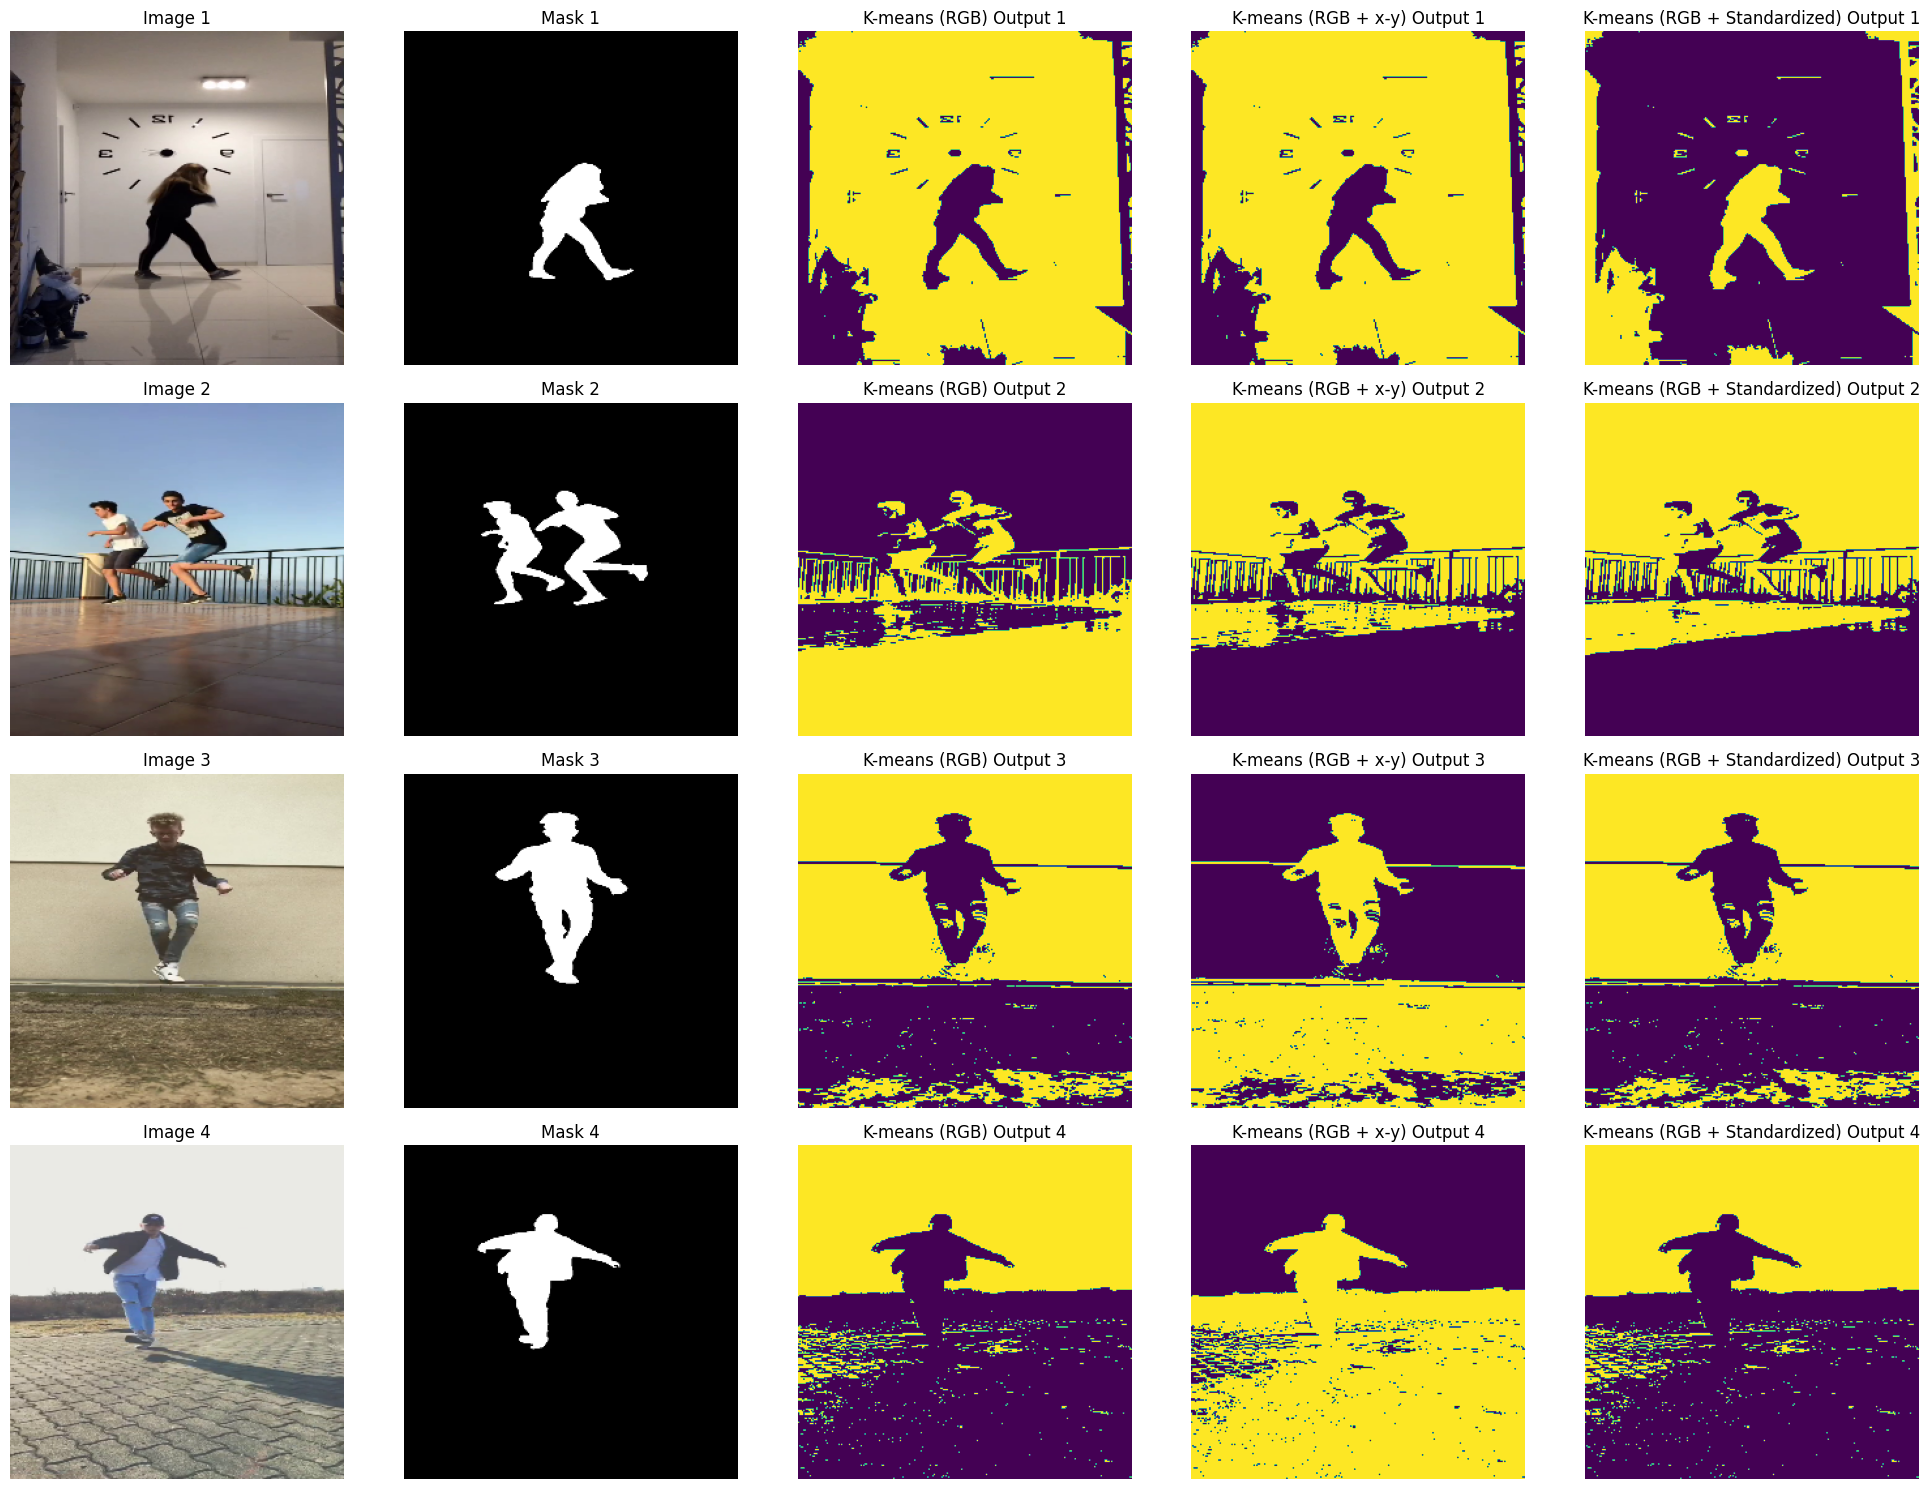

In [14]:
run_kmeans(2)

The study reveals that clustering performance improves with standardized features (RGB + Standardized) for k = 2, based on the silhouette score and Calinski-Harabasz index, and that RGB + XY performs better in IoU, indicating better segmentation accuracy. Standardizing features positively impacts clustering quality.



Metrics for K-means (RGB) Image 1:
IoU: 0.0753115197559642
Silhouette Score: 0.5553834000701185
Calinski-Harabasz Index: 177208.5699026697
Davies-Bouldin Index: 0.5465945922222617

Metrics for K-means (RGB + x-y) Image 1:
IoU: 0.0753115197559642
Silhouette Score: 0.5553834000701185
Calinski-Harabasz Index: 177208.5699026697
Davies-Bouldin Index: 0.5465945922222617

Metrics for K-means (RGB + Standardized) Image 1:
IoU: 0.0760055720006965
Silhouette Score: 0.5548917580993269
Calinski-Harabasz Index: 177170.90651568954
Davies-Bouldin Index: 0.5472848822038238

Metrics for K-means (RGB) Image 2:
IoU: 0.047150695535368714
Silhouette Score: 0.6067433747478005
Calinski-Harabasz Index: 214783.40893436817
Davies-Bouldin Index: 0.5943651102737467

Metrics for K-means (RGB + x-y) Image 2:
IoU: 0.10486636623869852
Silhouette Score: 0.6067494529412323
Calinski-Harabasz Index: 214783.45714904417
Davies-Bouldin Index: 0.5943720627804548

Metrics for K-means (RGB + Standardized) Image 2:
IoU: 0.1046

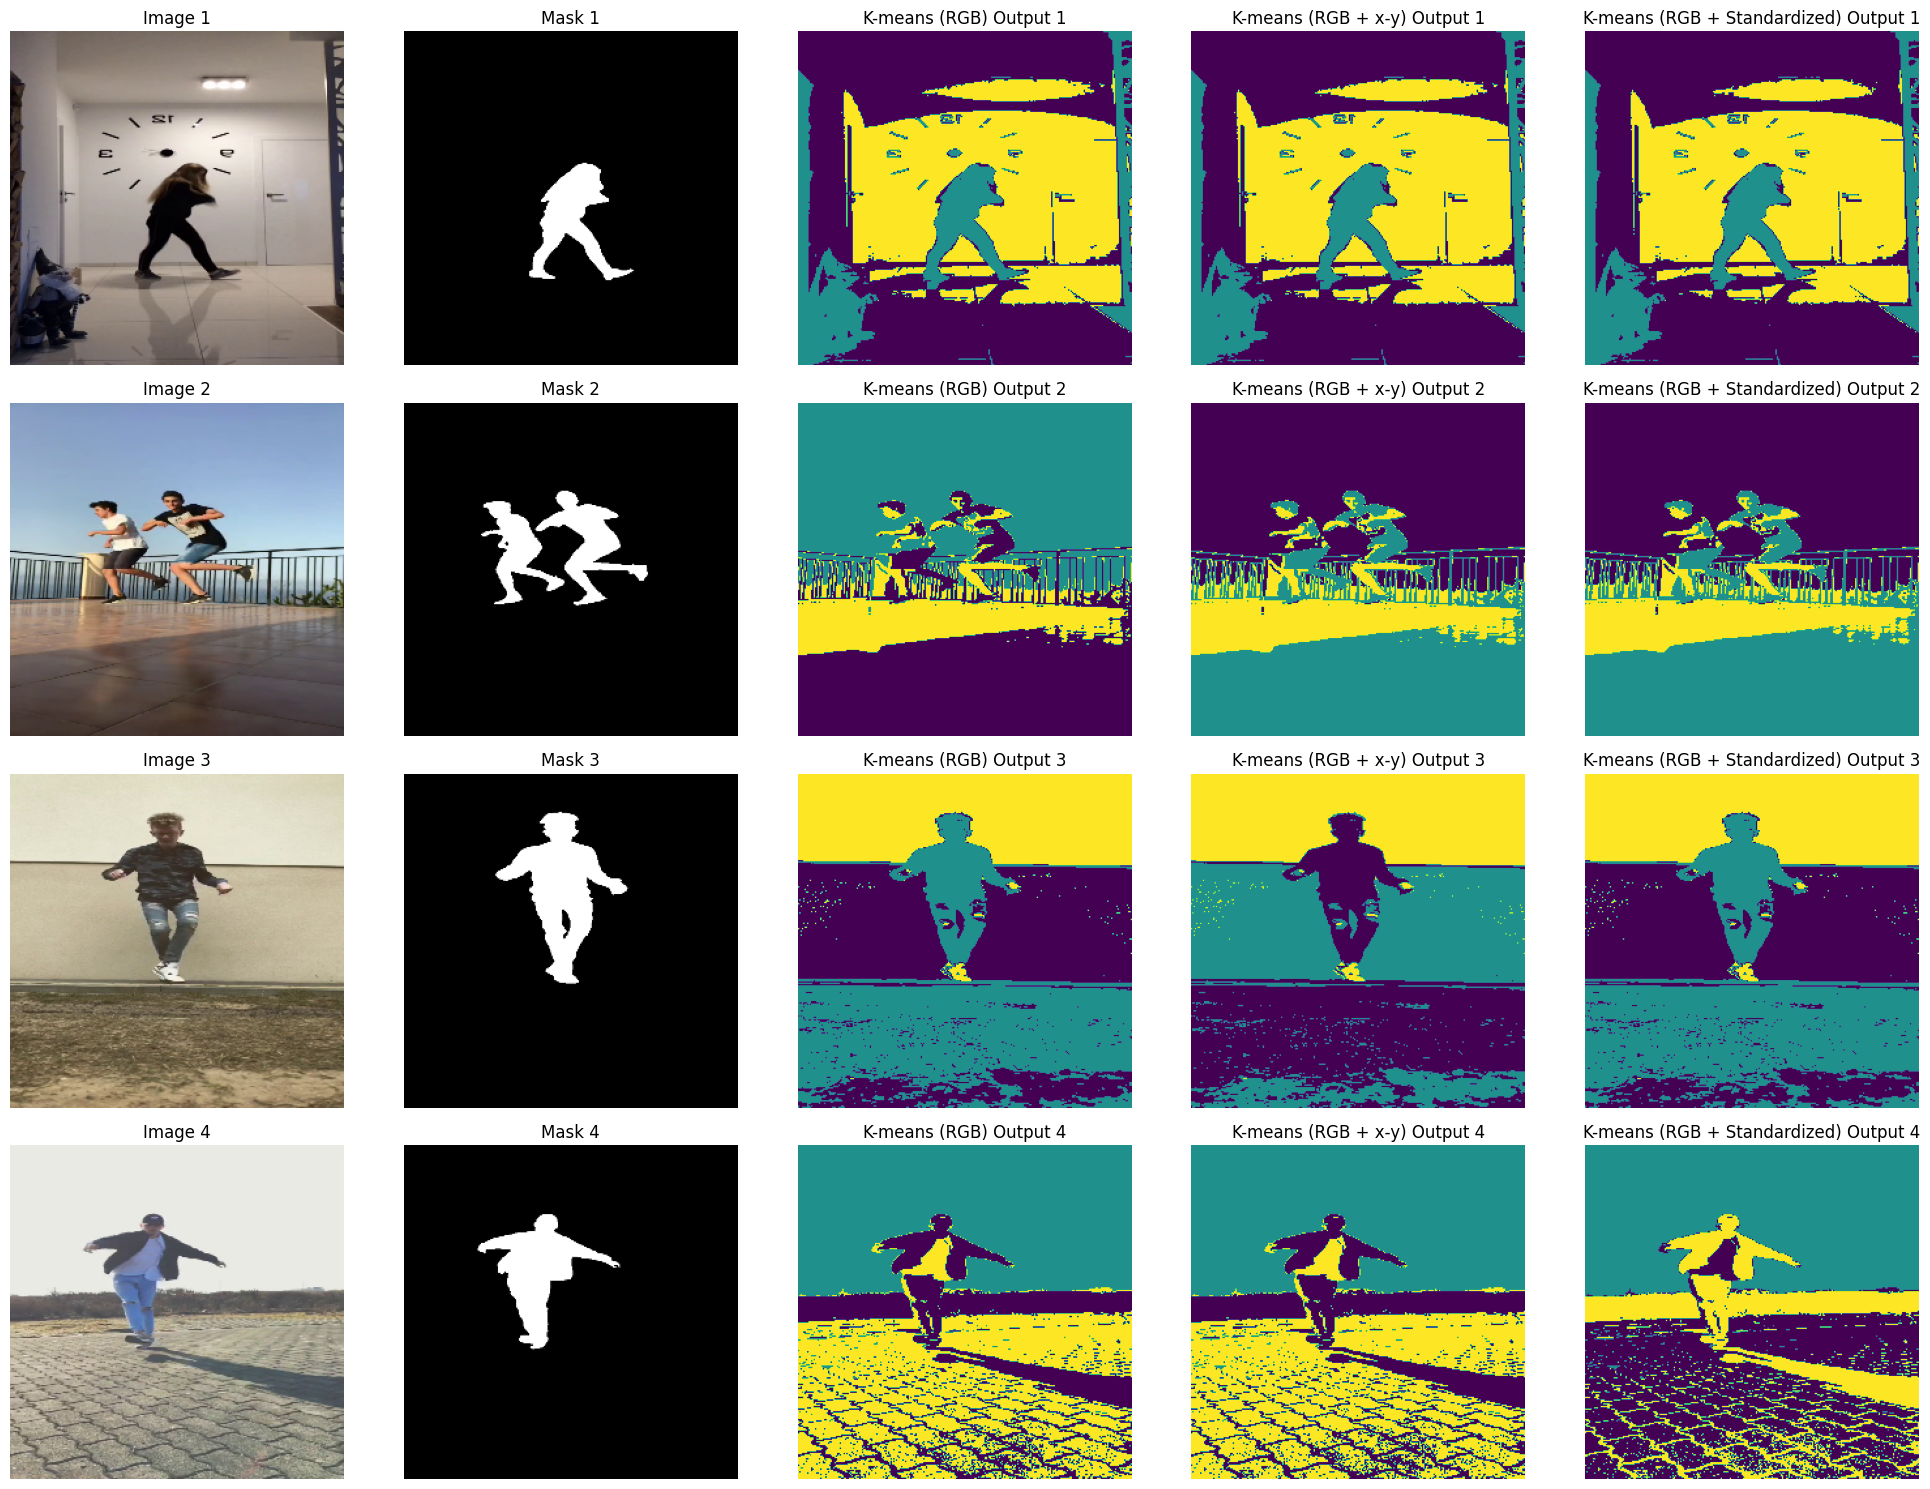

In [15]:
run_kmeans(3)

The study reveals that K-means on RGB features performs better in IoU, indicating better segmentation accuracy. K-means on RGB + standardized features consistently performs well across all metrics, indicating more well-defined and separated clusters. However, the inclusion of XY coordinates slightly impacts clustering quality. The performance trends across different feature spaces are consistent with k = 2, with RGB and standardized features outperforming other spaces. Adding XY coordinates slightly lowers performance compared to RGB alone.



Metrics for K-means (RGB) Image 1:
IoU: 0.04865824370888587
Silhouette Score: 0.484481350327082
Calinski-Harabasz Index: 378880.0543130725
Davies-Bouldin Index: 0.5870294513783955

Metrics for K-means (RGB + x-y) Image 1:
IoU: 0.01217256588203677
Silhouette Score: 0.48459917725209345
Calinski-Harabasz Index: 378876.28602400643
Davies-Bouldin Index: 0.5874525676579286

Metrics for K-means (RGB + Standardized) Image 1:
IoU: 0.050251802470924964
Silhouette Score: 0.4839604423476933
Calinski-Harabasz Index: 378320.7712419605
Davies-Bouldin Index: 0.5865473286000303

Metrics for K-means (RGB) Image 2:
IoU: 0.06918944340936635
Silhouette Score: 0.4400970676358793
Calinski-Harabasz Index: 213592.14640045338
Davies-Bouldin Index: 0.8134643535368327

Metrics for K-means (RGB + x-y) Image 2:
IoU: 0.05362820273050309
Silhouette Score: 0.44036031313478363
Calinski-Harabasz Index: 213598.85056359155
Davies-Bouldin Index: 0.8104175524986326

Metrics for K-means (RGB + Standardized) Image 2:
IoU: 0.

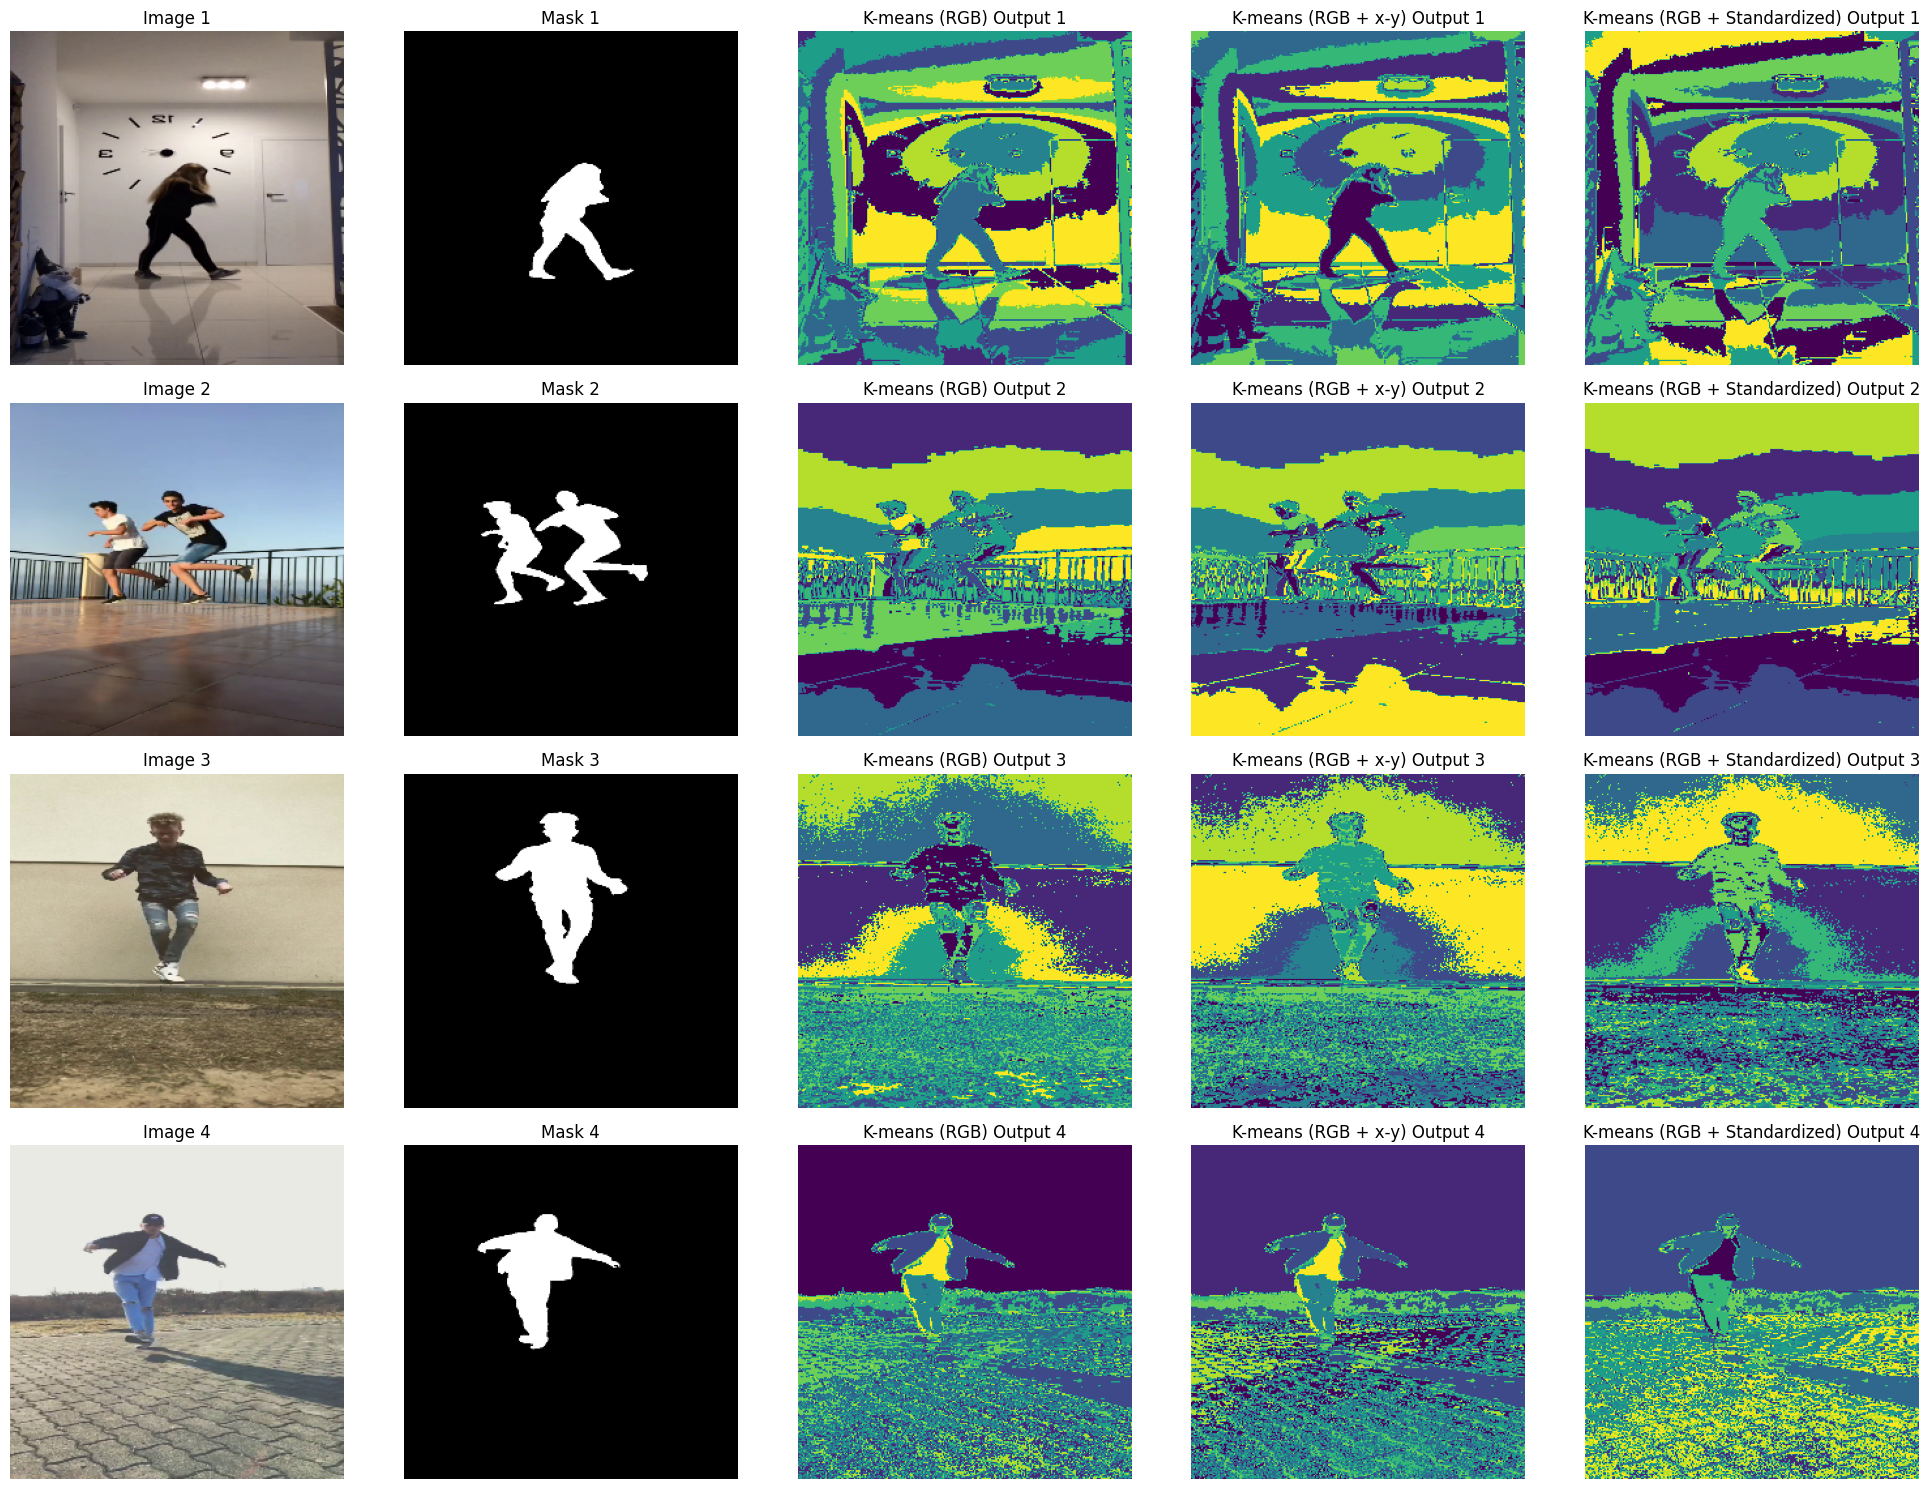

In [16]:
run_kmeans(10)

The study shows that increasing the number of clusters to 10 leads to reduced IoU values and less precise segmentation. However, K-means applied to RGB + standardized features consistently excels, resulting in more well-defined and separated clusters. The introduction of XY coordinates has a marginal adverse effect on clustering quality compared to using RGB features alone. K-means on RGB + standardized features is the most effective across all values of k, suggesting its resilience to variations in the number of clusters.

### Summary

In summary, increasing k in K-means clustering results in a more detailed segmentation of data, but it also poses the risk of overfitting to noise. It is crucial to strike a balance and choose a k value that captures meaningful patterns in the data without creating clusters for irrelevant fluctuations. Regularization techniques, validation methods, and domain knowledge can help in selecting an appropriate k value for a given dataset.


# **DBSCAN**



Metrics for DBSCAN RGB Image 1:
IoU: 0.0427474389703974
Silhouette Score: 0.03856340973268363
Calinski-Harabasz Index: 52.78977172570066
Davies-Bouldin Index: 3.2020579482898976

Metrics for DBSCAN RGB with xy Image 1:
IoU: 0.67583353614018
Silhouette Score: 0.07223994916105245
Calinski-Harabasz Index: 3997.417599171806
Davies-Bouldin Index: 1.282271760229568

Metrics for DBSCAN RGB with Standardization Image 1:
IoU: 0.21911290322580645
Silhouette Score: 0.43431322519396376
Calinski-Harabasz Index: 22967.186666462232
Davies-Bouldin Index: 1.6886568423454342

Metrics for DBSCAN RGB Image 2:
IoU: 0.06624022960429897
Silhouette Score: -0.06025143178267392
Calinski-Harabasz Index: 69.94045477738858
Davies-Bouldin Index: 0.9368785377379193

Metrics for DBSCAN RGB with xy Image 2:
IoU: 0.6256694037843628
Silhouette Score: -0.4022637732985697
Calinski-Harabasz Index: 661.7705243446518
Davies-Bouldin Index: 2.3826865040742757

Metrics for DBSCAN RGB with Standardization Image 2:
IoU: 0.103784

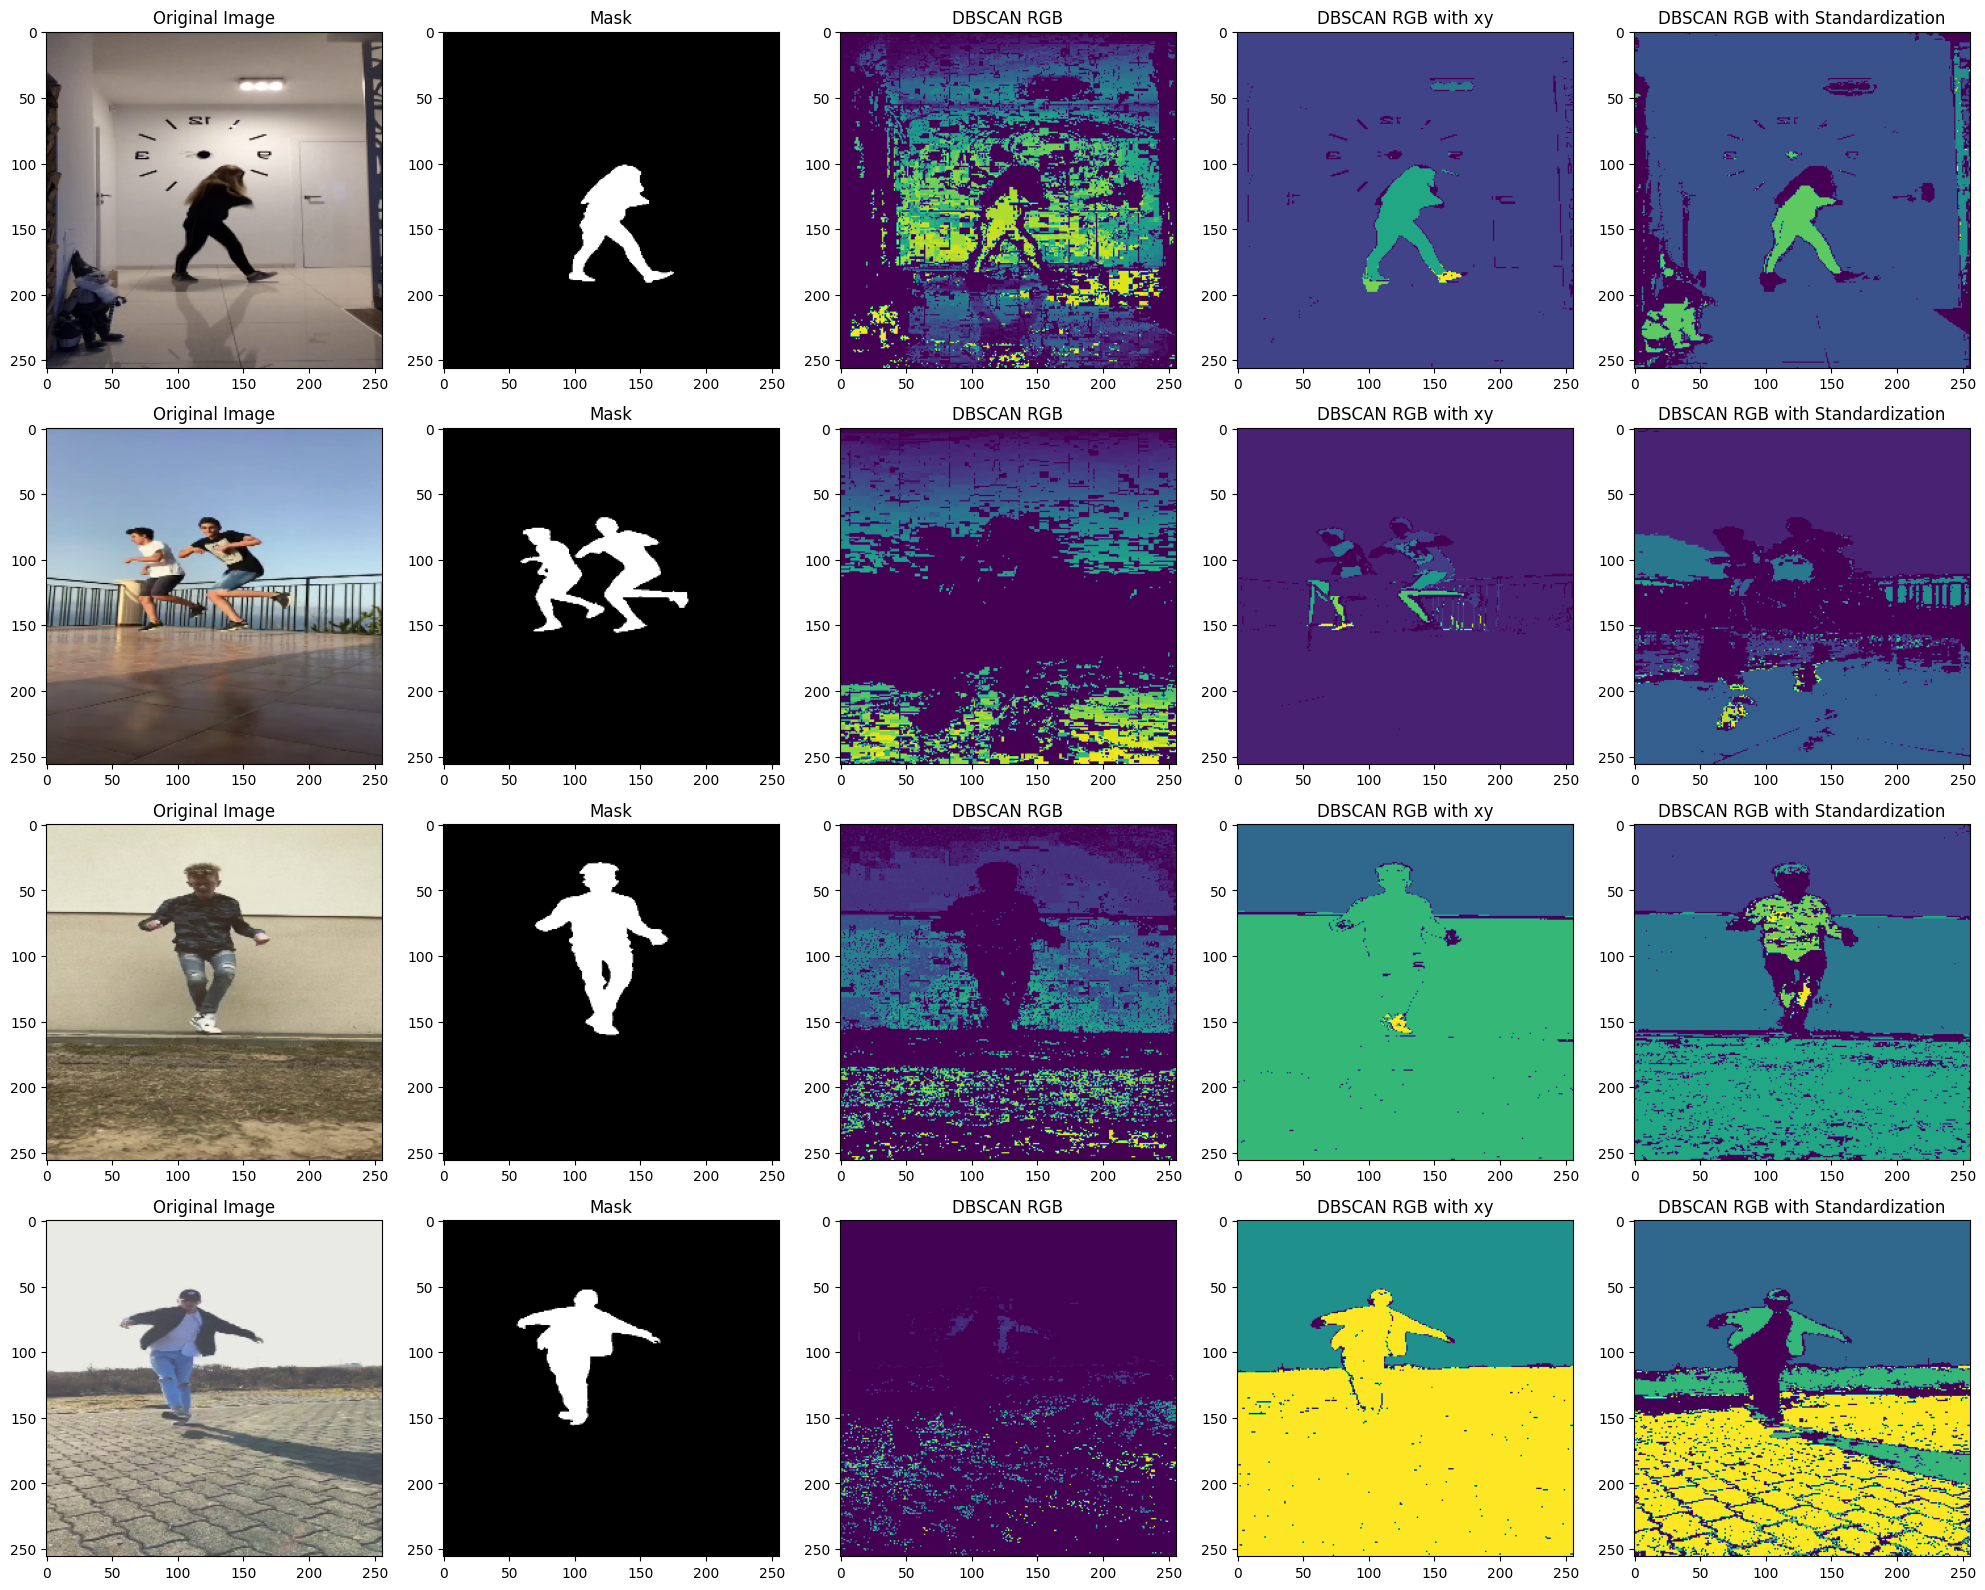

In [17]:
def apply_dbscan(image, method='RGB'):
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape((-1, 3))

    if method == 'RGB':
        # Apply DBSCAN clustering on RGB values
        dbscan = DBSCAN(eps=0.5, min_samples=20)
        labels = dbscan.fit_predict(pixels)
    elif method == 'RGB_XY':
        # Use x, y coordinates as features for DBSCAN
        xy_coordinates = np.column_stack(np.where(np.ones_like(image[..., 0])))
        features = np.column_stack((pixels, xy_coordinates))
        # Apply DBSCAN clustering on RGB and xy values
        dbscan = DBSCAN(eps=20, min_samples=50)
        labels = dbscan.fit_predict(features)

    elif method == 'RGB_Standardized':
        # Standardize the RGB values
        scaler = StandardScaler()
        pixels_standardized = scaler.fit_transform(pixels)
        # Apply DBSCAN clustering on standardized RGB values
        dbscan = DBSCAN(eps=0.05, min_samples=80)
        labels = dbscan.fit_predict(pixels_standardized)

    else:
        raise ValueError("Invalid clustering method. Choose from 'RGB', 'RGB_XY', or 'RGB_Standardized'.")
  
    # Reshape the labels to the original image shape
    segmented_image = labels.reshape(image.shape[0], image.shape[1])
    return segmented_image

average_iou_list = []
average_silhouette_list = []
average_calinski_harabasz_list = []
average_davies_bouldin_list = []

# Plot images, masks, and DBSCAN results
fig, axs = plt.subplots(4, 5, figsize=(20, 16))

for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
    # Load and preprocess image and mask
    image, mask = load_images(image_path, mask_path)

    # Plot original image
    axs[i, 0].imshow(image)
    axs[i, 0].set_title('Original Image')

    # Plot mask
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title('Mask')

    # Apply DBSCAN RGB
    segmented_rgb = apply_dbscan(image, method='RGB')
    axs[i, 2].imshow(segmented_rgb, cmap='viridis')
    axs[i, 2].set_title('DBSCAN RGB')

    iou, silhouette, calinski_harabasz, davies_bouldin = calculate_all_metrics(mask, segmented_rgb, image)
    print(f"\nMetrics for DBSCAN RGB Image {i+1}:")
    print(f"IoU: {iou}")
    print(f"Silhouette Score: {silhouette}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz}")
    print(f"Davies-Bouldin Index: {davies_bouldin}")

    # Apply DBSCAN RGB with xy
    segmented_xy = apply_dbscan(image, method='RGB_XY')
    axs[i, 3].imshow(segmented_xy, cmap='viridis')
    axs[i, 3].set_title('DBSCAN RGB with xy')

    iou_xy, silhouette_xy, calinski_harabasz_xy, davies_bouldin_xy = calculate_all_metrics(mask, segmented_xy, image)
    print(f"\nMetrics for DBSCAN RGB with xy Image {i+1}:")
    print(f"IoU: {iou_xy}")
    print(f"Silhouette Score: {silhouette_xy}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_xy}")
    print(f"Davies-Bouldin Index: {davies_bouldin_xy}")

    # Apply DBSCAN RGB with standardization
    segmented_standardized = apply_dbscan(image, method='RGB_Standardized')
    axs[i, 4].imshow(segmented_standardized, cmap='viridis')
    axs[i, 4].set_title('DBSCAN RGB with Standardization')

    iou_std, silhouette_std, calinski_harabasz_std, davies_bouldin_std = calculate_all_metrics(mask, segmented_standardized, image)
    print(f"\nMetrics for DBSCAN RGB with Standardization Image {i+1}:")
    print(f"IoU: {iou_std}")
    print(f"Silhouette Score: {silhouette_std}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_std}")
    print(f"Davies-Bouldin Index: {davies_bouldin_std}")

    average_iou_list.extend([iou, iou_xy, iou_std])
    average_silhouette_list.extend([silhouette, silhouette_xy, silhouette_std])
    average_calinski_harabasz_list.extend([calinski_harabasz, calinski_harabasz_xy, calinski_harabasz_std])
    average_davies_bouldin_list.extend([davies_bouldin, davies_bouldin_xy, davies_bouldin_std])

# Calculate average metrics for each case of GMM
average_iou_rgb = np.mean(average_iou_list[0:3])
average_iou_rgb_standardized = np.mean(average_iou_list[3:6])
average_iou_rgb_xy = np.mean(average_iou_list[6:9])

average_silhouette_rgb = np.mean(average_silhouette_list[0:3])
average_silhouette_rgb_standardized = np.mean(average_silhouette_list[3:6])
average_silhouette_rgb_xy = np.mean(average_silhouette_list[6:9])

average_calinski_harabasz_rgb = np.mean(average_calinski_harabasz_list[0:3])
average_calinski_harabasz_rgb_standardized = np.mean(average_calinski_harabasz_list[3:6])
average_calinski_harabasz_rgb_xy = np.mean(average_calinski_harabasz_list[6:9])

average_davies_bouldin_rgb = np.mean(average_davies_bouldin_list[0:3])
average_davies_bouldin_rgb_standardized = np.mean(average_davies_bouldin_list[3:6])
average_davies_bouldin_rgb_xy = np.mean(average_davies_bouldin_list[6:9])

# Print results
print("\nAverage IoU:")
print(f"DBSCAN RGB: {average_iou_rgb}")
print(f"DBSCAN RGB + Standardized: {average_iou_rgb_standardized}")
print(f"DBSCAN RGB + XY: {average_iou_rgb_xy}")

print("\nAverage Silhouette Score:")
print(f"DBSCAN RGB: {average_silhouette_rgb}")
print(f"DBSCAN RGB + Standardized: {average_silhouette_rgb_standardized}")
print(f"DBSCAN RGB + XY: {average_silhouette_rgb_xy}")

print("\nAverage Calinski-Harabasz Index:")
print(f"DBSCAN RGB: {average_calinski_harabasz_rgb}")
print(f"DBSCAN RGB + Standardized: {average_calinski_harabasz_rgb_standardized}")
print(f"DBSCAN RGB + XY: {average_calinski_harabasz_rgb_xy}")

print("\nAverage Davies-Bouldin Index:")
print(f"DBSCAN RGB: {average_davies_bouldin_rgb}")
print(f"DBSCAN RGB + Standardized: {average_davies_bouldin_rgb_standardized}")
print(f"DBSCAN RGB + XY: {average_davies_bouldin_rgb_xy}")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

## Discussing the code

The code uses the DBSCAN clustering algorithm to analyze images using various methods. It reshapes the image pixels and applies the algorithm based on the specified method, which includes 'RGB', 'RGB_XY', and 'RGB_Standardized'. The main loop iterates over image and mask paths, loads and preprocesses the image and mask, displays the original image and mask, and applies DBSCAN clustering for each method. After clustering, it calculates and prints metrics like the IoU, silhouette score, Calinski-Harabasz index, and Davies-Bouldin index. The code then calculates and prints the average metrics for each case of the DBSCAN clustering method, displaying the results in a grid layout for visual inspection.

#### Hyperparameters

The parameters `eps` and `min_samples` are crucial in determining the effectiveness of DBSCAN clustering. They define the radius (`eps`) within which points are considered neighbors and the minimum number of points required to form a dense region. The code has experimented with different values for these parameters, finding suitable ones for each DBSCAN method.

For the 'RGB' method, the `eps` value of 0.5 and a `min_samples` value of 20 are chosen, defining a relatively tight cluster and a moderate density requirement. The 'RGB_XY' method incorporates XY coordinates along with RGB values, with a larger `eps` of 20 and a higher `min_samples` of 50. The 'RGB_Standardized' method uses a smaller `eps` of 0.05 and a higher `min_samples` of 80, indicating more compact clusters and a stricter density criterion.

The parameter adjustments across the three methods reflect the nature of the features being considered, as the inclusion of XY coordinates and standardization of RGB values alter the scale and distribution of the data, influencing the appropriate parameter values for optimal clustering.


The DBSCAN clustering results show variations in performance across multiple metrics. The RGB representation yields the highest IoU, indicating better overlap between clusters identified by DBSCAN and ground truth masks. Standardizing RGB features results in a slightly lower IoU compared to the RGB representation. The inclusion of XY coordinates leads to a significant decrease in IoU, suggesting that XY features might not contribute positively to cluster quality. The silhouette score is positive, indicating well-separated clusters in the RGB representation. The Calinski-Harabasz Index measures the ratio of between-cluster variance to within-cluster variance, with higher values indicating better-defined clusters. Standardization of RGB features results in a lower Calinski-Harabasz index, suggesting less distinct clusters. The inclusion of XY coordinates leads to a significantly higher index, indicating more well-defined clusters. The Davies-Bouldin Index evaluates cluster compactness and separation, with a lower index being better. The choice of feature representation in DBSCAN should be carefully considered based on the specific clustering objectives and the characteristics of the data.


# **GMM**


In [18]:
def run_gmm(num_clusters):
    def apply_gmm(image_flattened):
        # Apply Gaussian Mixture Model clustering with 2 components (you can adjust as needed)
        gmm = GaussianMixture(n_components=num_clusters, random_state=42)
        gmm.fit(image_flattened)
        segmented_image = gmm.predict(image_flattened).reshape((256, 256))

        # Normalize pixel values to [0, 1]
        segmented_image = segmented_image / np.max(segmented_image)

        return segmented_image

    def apply_gmm_rgb_xy(image):
        # Get XY coordinates
        x, y = np.meshgrid(np.arange(256), np.arange(256))
        xy_coords = np.column_stack((x.flatten(), y.flatten()))

        # Flatten the image for GMM with RGB + XY
        image_flattened = np.column_stack((image.reshape((-1, 3)), xy_coords))

        # Apply GMM clustering
        gmm = GaussianMixture(n_components=num_clusters, random_state=42)
        gmm.fit(image_flattened)
        segmented_image = gmm.predict(image_flattened).reshape((256, 256))

        # Normalize pixel values to [0, 1]
        segmented_image = segmented_image / np.max(segmented_image)

        return segmented_image


    # Set up a subplot grid
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    # Initialize a scaler for standardization
    scaler = StandardScaler()

    # Initialize lists to store metrics
    average_iou_list = []
    average_silhouette_list = []
    average_calinski_harabasz_list = []
    average_davies_bouldin_list = []

    # Iterate over image and mask paths
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Load and preprocess the image and mask
        image, mask = load_images(image_path, mask_path)

        # Plot the original image
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i + 1}")

        # Plot the mask
        axes[i, 1].imshow(mask)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Mask {i + 1}")

        # Apply GMM clustering to the original image
        gmm_output_rgb = apply_gmm(image.reshape((-1, 3)))
        iou, silhouette, calinski_harabasz, davies_bouldin = calculate_all_metrics(mask, gmm_output_rgb, image)
        print(f"\nMetrics for GMM RGB Image {i + 1}:")
        print(f"IoU: {iou}")
        print(f"Silhouette Score: {silhouette}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz}")
        print(f"Davies-Bouldin Index: {davies_bouldin}")

        # Plot the output of GMM clustering (RGB)
        axes[i, 2].imshow(gmm_output_rgb)
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"GMM RGB {i + 1}")


        # Apply GMM clustering to the image with x-y coordinates
        gmm_output_rgb_xy = apply_gmm_rgb_xy(image)
        iou_xy, silhouette_xy, calinski_harabasz_xy, davies_bouldin_xy = calculate_all_metrics(mask, gmm_output_rgb_xy, image)
        print(f"\nMetrics for GMM RGB + XY Image {i + 1}:")
        print(f"IoU: {iou_xy}")
        print(f"Silhouette Score: {silhouette_xy}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_xy}")
        print(f"Davies-Bouldin Index: {davies_bouldin_xy}")

        # Plot the output of GMM clustering (RGB + Standardized)
        axes[i, 3].imshow(gmm_output_rgb_xy)
        axes[i, 3].axis('off')
        axes[i, 3].set_title(f"GMM RGB + XY {i + 1}")


        # Standardize RGB features before clustering
        image_standardized = scaler.fit_transform(image.reshape((-1, 3)))

        # Apply GMM clustering to the standardized image
        gmm_output_rgb_standardized = apply_gmm(image_standardized)
        iou_std, silhouette_std, calinski_harabasz_std, davies_bouldin_std = calculate_all_metrics(mask, gmm_output_rgb_standardized, image)
        print(f"\nMetrics for GMM RGB + Standardized Image {i + 1}:")
        print(f"IoU: {iou_std}")
        print(f"Silhouette Score: {silhouette_std}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz_std}")
        print(f"Davies-Bouldin Index: {davies_bouldin_std}")

        # Plot the output of GMM clustering (RGB + XY)
        axes[i, 4].imshow(gmm_output_rgb_standardized)
        axes[i, 4].axis('off')
        axes[i, 4].set_title(f"GMM RGB + Standardized {i + 1}")

        # Append metrics to lists
        average_iou_list.extend([iou, iou_xy, iou_std])
        average_silhouette_list.extend([silhouette, silhouette_xy, silhouette_std])
        average_calinski_harabasz_list.extend([calinski_harabasz, calinski_harabasz_xy, calinski_harabasz_std])
        average_davies_bouldin_list.extend([davies_bouldin, davies_bouldin_xy, davies_bouldin_std])
        
    # Calculate average metrics for each case of GMM
    average_iou_rgb = np.mean(average_iou_list[0:3])
    average_iou_rgb_standardized = np.mean(average_iou_list[3:6])
    average_iou_rgb_xy = np.mean(average_iou_list[6:9])

    average_silhouette_rgb = np.mean(average_silhouette_list[0:3])
    average_silhouette_rgb_standardized = np.mean(average_silhouette_list[3:6])
    average_silhouette_rgb_xy = np.mean(average_silhouette_list[6:9])

    average_calinski_harabasz_rgb = np.mean(average_calinski_harabasz_list[0:3])
    average_calinski_harabasz_rgb_standardized = np.mean(average_calinski_harabasz_list[3:6])
    average_calinski_harabasz_rgb_xy = np.mean(average_calinski_harabasz_list[6:9])

    average_davies_bouldin_rgb = np.mean(average_davies_bouldin_list[0:3])
    average_davies_bouldin_rgb_standardized = np.mean(average_davies_bouldin_list[3:6])
    average_davies_bouldin_rgb_xy = np.mean(average_davies_bouldin_list[6:9])

    # Print results
    print("\nAverage IoU:")
    print(f"GMM RGB: {average_iou_rgb}")
    print(f"GMM RGB + Standardized: {average_iou_rgb_standardized}")
    print(f"GMM RGB + XY: {average_iou_rgb_xy}")

    print("\nAverage Silhouette Score:")
    print(f"GMM RGB: {average_silhouette_rgb}")
    print(f"GMM RGB + Standardized: {average_silhouette_rgb_standardized}")
    print(f"GMM RGB + XY: {average_silhouette_rgb_xy}")

    print("\nAverage Calinski-Harabasz Index:")
    print(f"GMM RGB: {average_calinski_harabasz_rgb}")
    print(f"GMM RGB + Standardized: {average_calinski_harabasz_rgb_standardized}")
    print(f"GMM RGB + XY: {average_calinski_harabasz_rgb_xy}")

    print("\nAverage Davies-Bouldin Index:")
    print(f"GMM RGB: {average_davies_bouldin_rgb}")
    print(f"GMM RGB + Standardized: {average_davies_bouldin_rgb_standardized}")
    print(f"GMM RGB + XY: {average_davies_bouldin_rgb_xy}")

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()


## Discussing the code

The GMM (Gaussian Mixture Model) code is a comprehensive analysis of GMM clustering using different feature sets and evaluating performance using various metrics. It includes the `apply_gmm_rgb_xy` function, which extends GMM clustering to include XY coordinates and RGB values. RGB features are standardized using the `StandardScaler` from scikit-learn, ensuring a mean of 0 and a standard deviation of 1. The code also includes a subplot grid to visualize the original images, masks, and GMM clustering results. Metrics such as IoU, silhouette score, Calinski-Harabasz index, and Davies-Bouldin index are calculated for each case of GMM clustering. The code also adjusts parameters and calculates average metrics for each GMM method.



Metrics for GMM RGB Image 1:
IoU: 0.19642306506321308
Silhouette Score: 0.5593604305664778
Calinski-Harabasz Index: 78140.38702223806
Davies-Bouldin Index: 0.642809719229339

Metrics for GMM RGB + XY Image 1:
IoU: 0.00032449972958355867
Silhouette Score: 0.18703395854426513
Calinski-Harabasz Index: 27245.179702132173
Davies-Bouldin Index: 1.2770293225212561

Metrics for GMM RGB + Standardized Image 1:
IoU: 0.19632659361012503
Silhouette Score: 0.5595810809152436
Calinski-Harabasz Index: 78110.76973921766
Davies-Bouldin Index: 0.6423254035082749

Metrics for GMM RGB Image 2:
IoU: 0.0011720358579619247
Silhouette Score: 0.5202721086010224
Calinski-Harabasz Index: 78993.80160771651
Davies-Bouldin Index: 0.6428355400981727

Metrics for GMM RGB + XY Image 2:
IoU: 6.653802648213454e-05
Silhouette Score: 0.47289625416920733
Calinski-Harabasz Index: 58425.48104659402
Davies-Bouldin Index: 0.7124787986252927

Metrics for GMM RGB + Standardized Image 2:
IoU: 0.04828431961911174
Silhouette Score

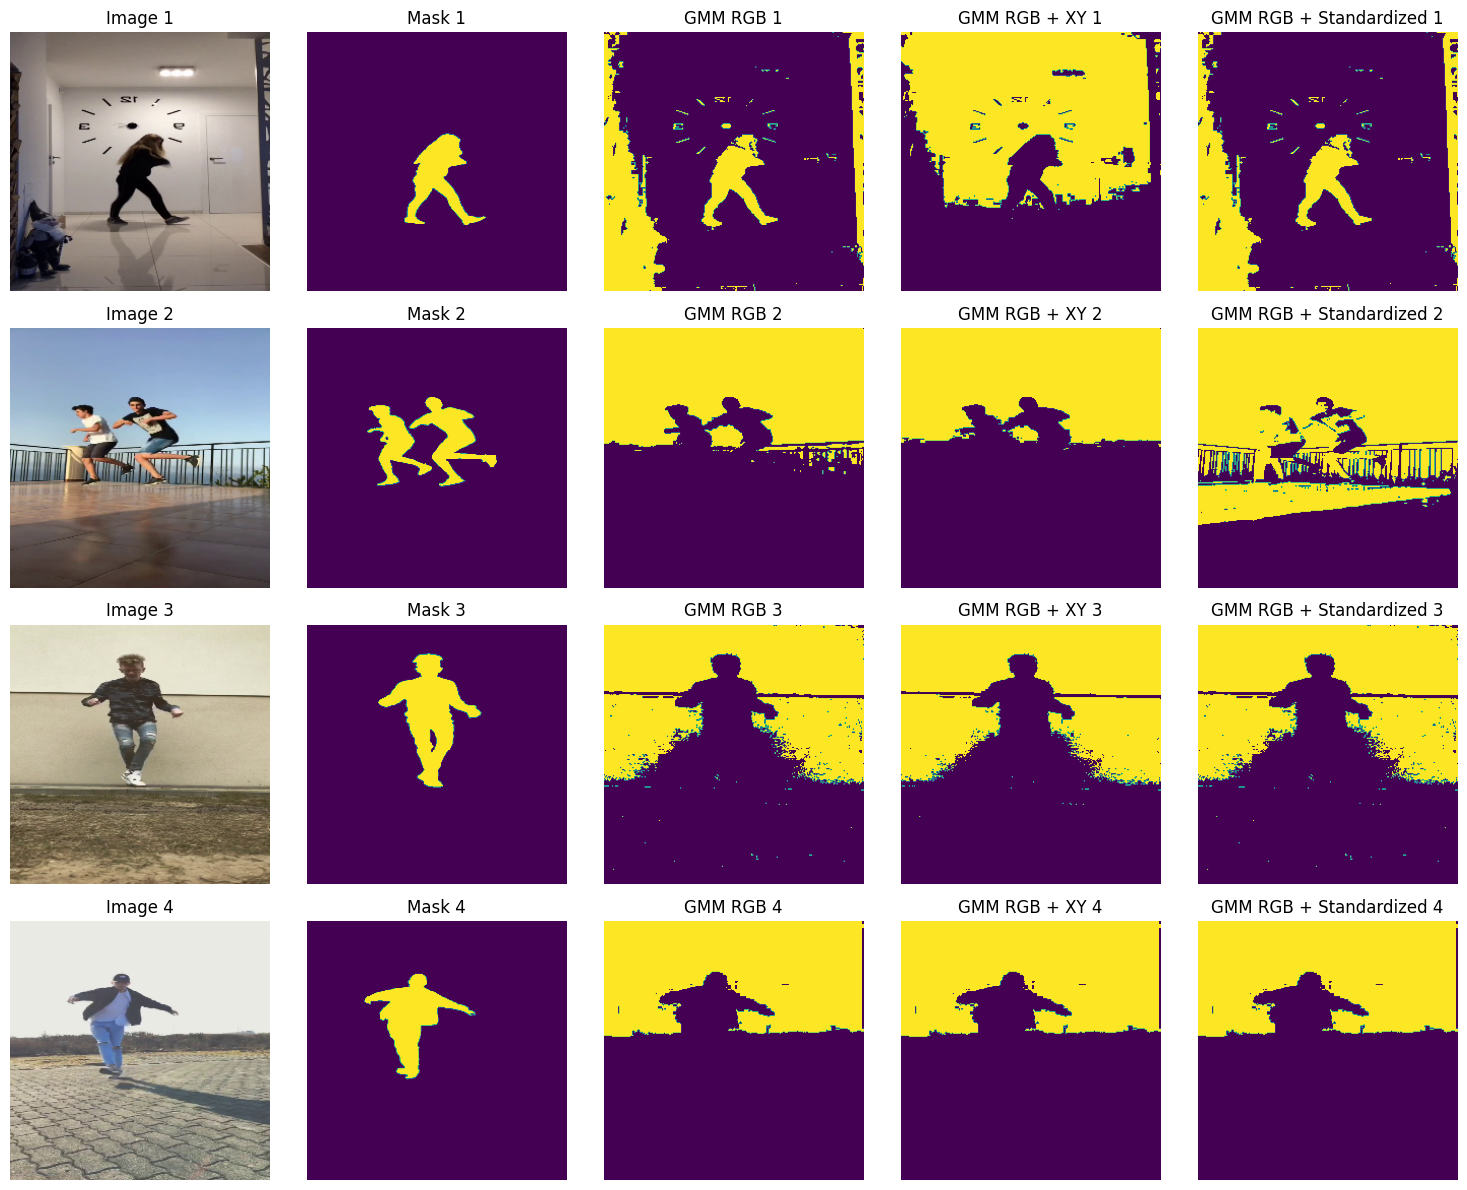

In [19]:
run_gmm(2)

GMM with RGB + XY features performs the best among the three representations, with higher Silhouette Score and Calinski-Harabasz Index. Standardization of features generally improves clustering performance, but the overall quality remains limited, especially in terms of IoU. The choice of feature representation and the performance metrics should be considered based on the specific objectives and characteristics of the data.



Metrics for GMM RGB Image 1:
IoU: 0.08280828082808281
Silhouette Score: 0.4377330983549709
Calinski-Harabasz Index: 114116.40254204144
Davies-Bouldin Index: 0.6692059785983461

Metrics for GMM RGB + XY Image 1:
IoU: 0.00040564211302664333
Silhouette Score: 0.07892517481016299
Calinski-Harabasz Index: 40585.53034434764
Davies-Bouldin Index: 1.9874095217800798

Metrics for GMM RGB + Standardized Image 1:
IoU: 0.08286158631415241
Silhouette Score: 0.43983009148852814
Calinski-Harabasz Index: 115872.0720069702
Davies-Bouldin Index: 0.6652929406711136

Metrics for GMM RGB Image 2:
IoU: 0.08399379376860822
Silhouette Score: 0.4036514013149288
Calinski-Harabasz Index: 55677.05925430768
Davies-Bouldin Index: 1.0467886249322962

Metrics for GMM RGB + XY Image 2:
IoU: 0.10691000691494616
Silhouette Score: 0.37091441327703933
Calinski-Harabasz Index: 37495.37749977318
Davies-Bouldin Index: 1.670436824308647

Metrics for GMM RGB + Standardized Image 2:
IoU: 0.08406624546084256
Silhouette Score: 0

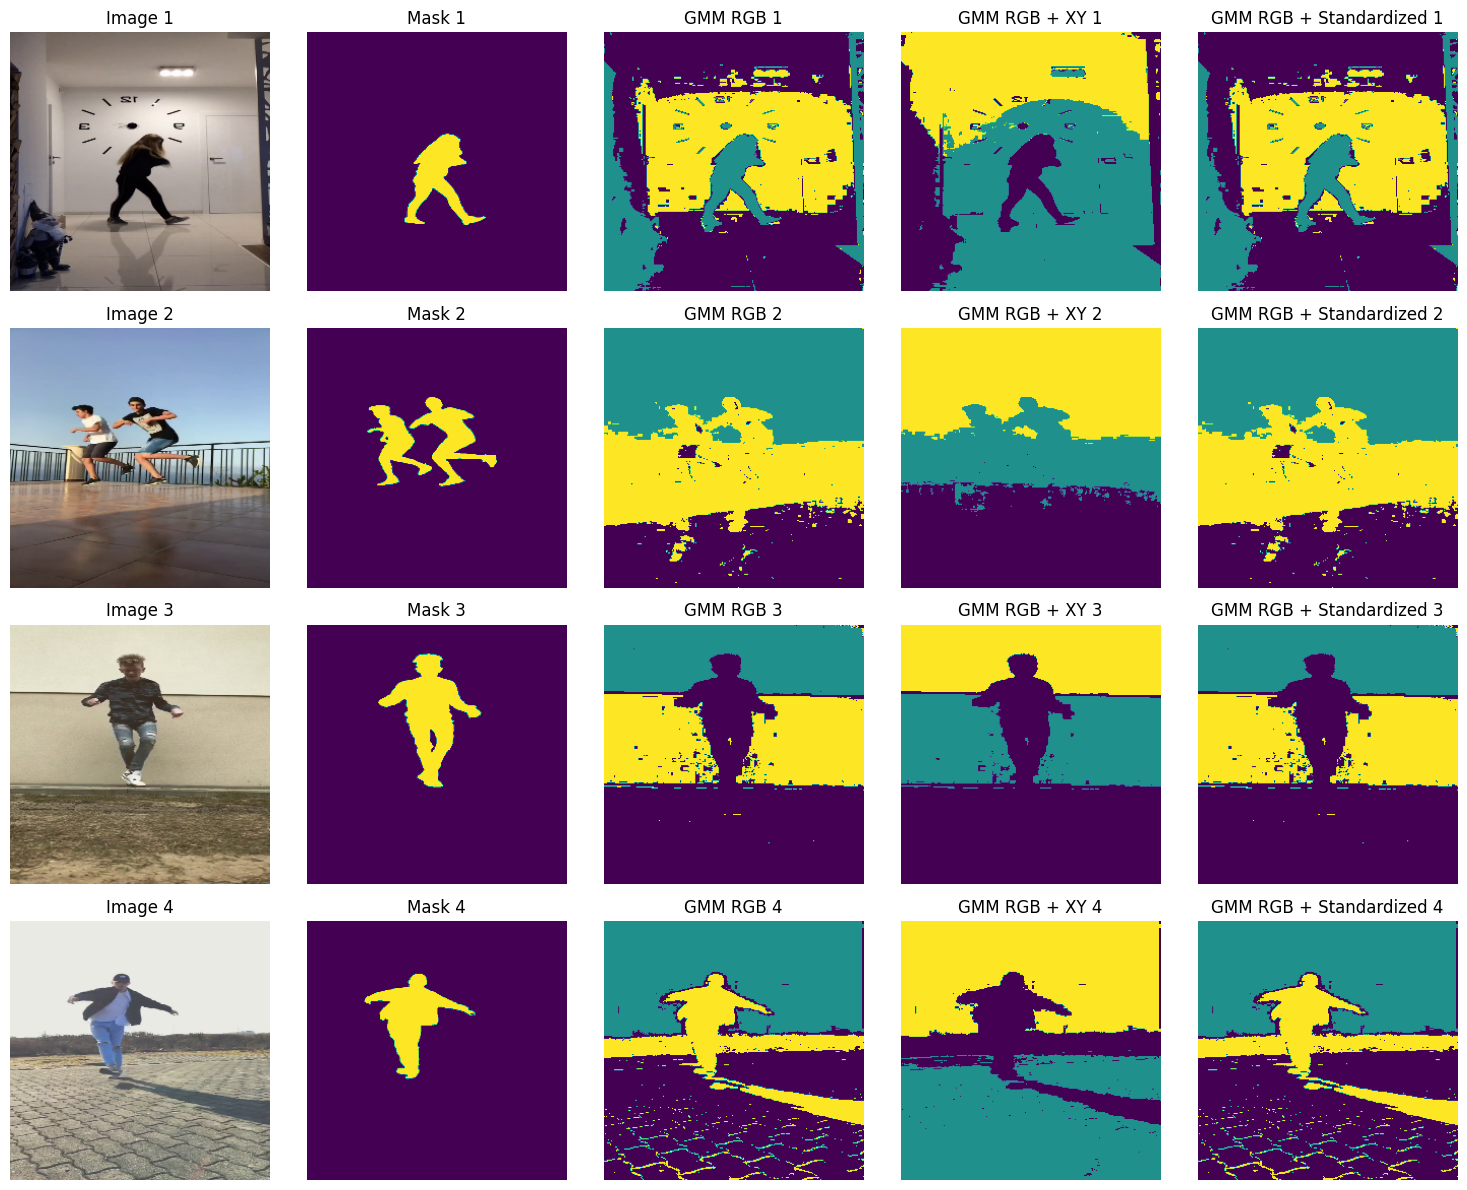

In [20]:
run_gmm(3)

The GMM RGB model shows varying IoU values, with lower overlap between clusters and ground truth masks. Standardized features improve segmentation, while XY coordinates have a limited positive effect. The Silhouette Score decreases, suggesting less well-separated clusters. The Calinski-Harabasz Index decreases, suggesting a different cluster structure. The Davies-Bouldin Index increases slightly, indicating a change in cluster compactness and separation. The inclusion of XY coordinates leads to a lower Davies-Bouldin Index, indicating improved cluster quality. Comparing to `k=2`, the IoU decreases with increasing cluster size, suggesting reduced overlap with ground truth masks. The Silhouette Score improves with XY coordinates. The Calinski-Harabasz Index balances between clusters, with RGB + XY representations performing best.



Metrics for GMM RGB Image 1:
IoU: 0.053495405598042806
Silhouette Score: 0.15096974508226213
Calinski-Harabasz Index: 102837.8077858479
Davies-Bouldin Index: 1.4562644516844683

Metrics for GMM RGB + XY Image 1:
IoU: 0.04730917449800554
Silhouette Score: -0.15554576542747958
Calinski-Harabasz Index: 16684.6699270701
Davies-Bouldin Index: 3.4142897184353145

Metrics for GMM RGB + Standardized Image 1:
IoU: 0.060653256410818875
Silhouette Score: 0.05647609594294388
Calinski-Harabasz Index: 58364.87769497855
Davies-Bouldin Index: 2.0868332782484496

Metrics for GMM RGB Image 2:
IoU: 0.07376169033598892
Silhouette Score: 0.28973870573753974
Calinski-Harabasz Index: 59804.58824231193
Davies-Bouldin Index: 2.3278082187843183

Metrics for GMM RGB + XY Image 2:
IoU: 0.07438285900536942
Silhouette Score: -0.010161795828585684
Calinski-Harabasz Index: 34265.76721978776
Davies-Bouldin Index: 5.557556603381372

Metrics for GMM RGB + Standardized Image 2:
IoU: 0.06997138842331589
Silhouette Score:

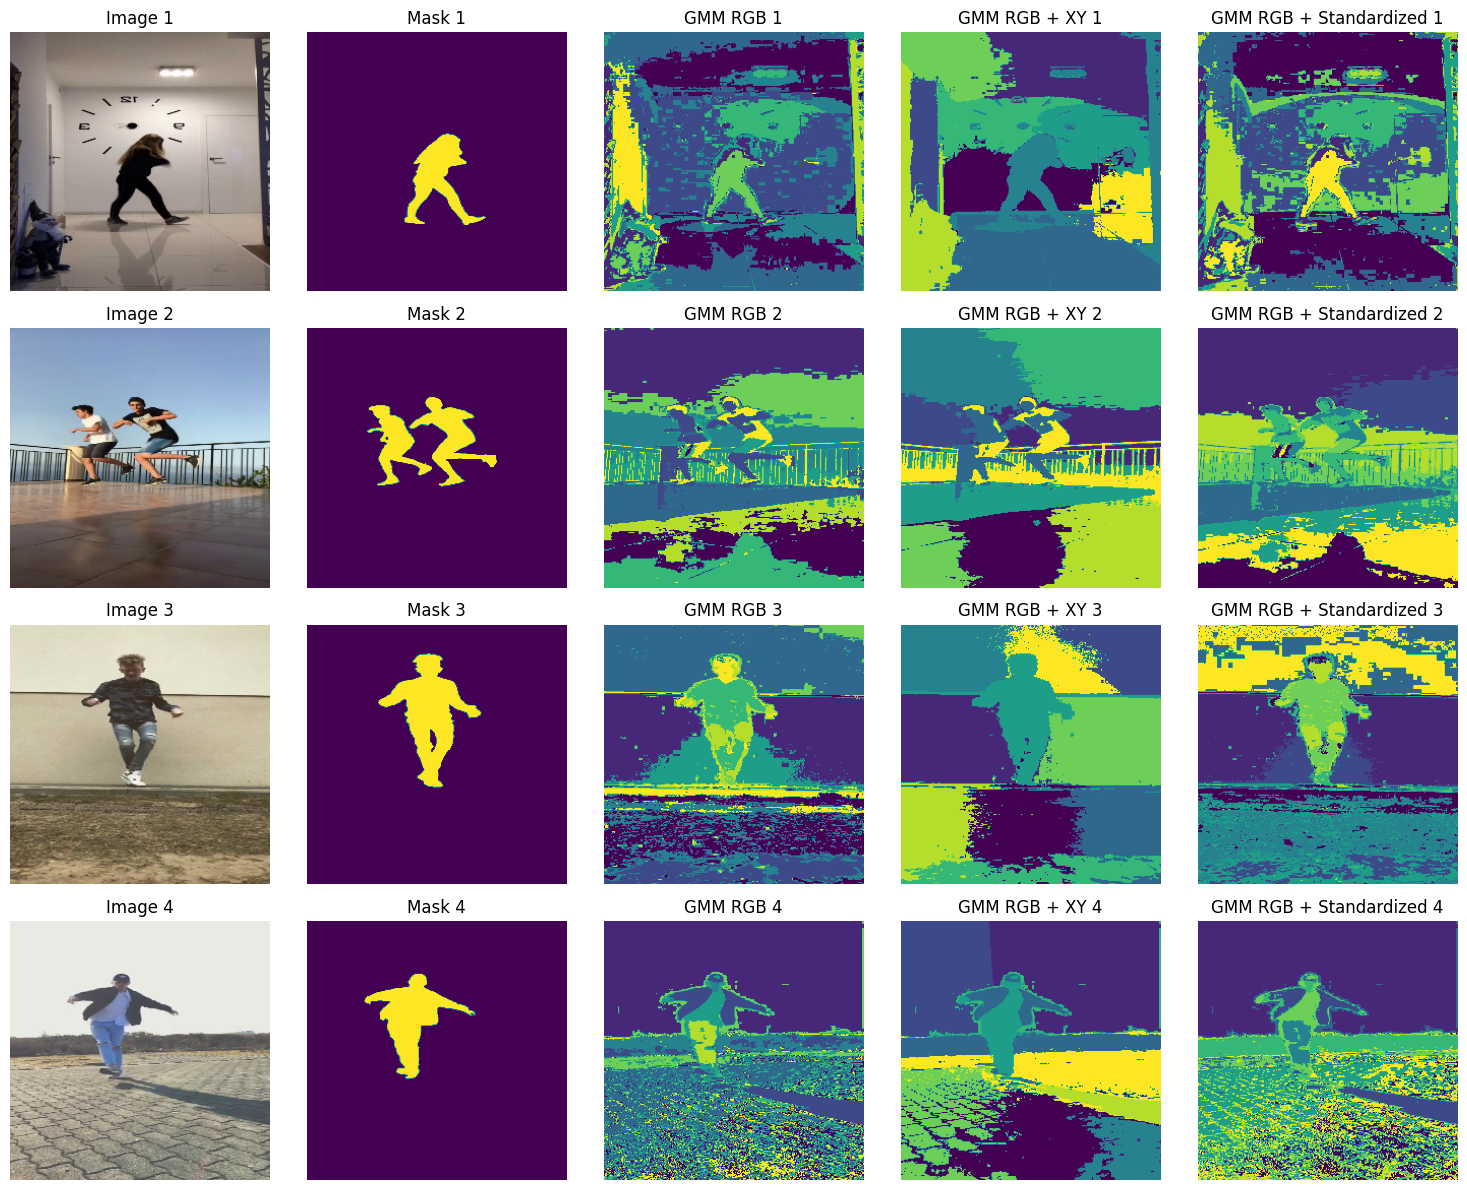

In [21]:
run_gmm(10)

The GMM RGB+XY image segmentation performance is analyzed using various features. The average IoU is low, suggesting poor segmentation. The silhouette score is low, indicating overlapping clusters and poor cluster separation. Standardized features improve the silhouette score, suggesting better-defined clusters. The Calinski-Harabasz Index is high but lower, indicating a different balance between within-cluster and between-cluster variance. The Davies-Bouldin index is high, indicating suboptimal compactness and separation of clusters. The negative silhouette score and Davies-Bouldin index values in some of the images suggest clusters are overlapping and not well-separated. These negative values suggest challenges in achieving well-defined and separated clusters with the chosen clustering configuration and feature representation.


### Summary

In summary, increasing k in GMM leads to a more detailed and flexible representation of the data, but it also allows the model to capture noise as components. The soft assignment nature of GMM makes it more suitable for handling noise and modeling complex data distributions compared to hard assignment methods like K-means. Selecting an appropriate k involves considering a trade-off between model complexity and the ability to capture meaningful patterns in the data.


# Conclusion

To sum up, a thorough investigation of clustering techniques, such as K-means, DBSCAN, and GMM, uncovers interesting patterns and trends in the segmentation of images. K-means performs best with uniform RGB features and shows sensitivity to the number of clusters (k). But as k increases, its noise sensitivity becomes apparent, which could result in over-segmentation. Using XY coordinates to provide spatial information, DBSCAN exhibits robustness to changing k values; nonetheless, in order to achieve the best results, it is necessary to carefully adjust parameters such as epsilon (eps) and min_samples. Interestingly, preprocessing by feature standardization improves clustering quality in a uniform manner for all approaches, highlighting the importance of data preparation. Furthermore, the effect of preprocessing methods and feature space manipulation on clustering results is significant. As seen in the K-means and DBSCAN investigations, standardizing features helps to align variable scales, which leads to more dependable and consistent clustering results. Standardization, in particular, enhances K-means' performance on RGB features, highlighting the significance of preprocessing for obtaining the best possible grouping. Furthermore, adding XY coordinates as extra features to K-means and DBSCAN adds spatial information that affects the clustering outcomes. Nevertheless, not all scenarios benefit uniformly from this spatial information, highlighting the need to comprehend the particular features of the data. The subtleties of feature space editing and preprocessing highlight the necessity of choosing procedures with care, taking into account the unique characteristics of the data being examined.